# ocrobin

Automatic binarization using deep learning.

This implements a grayscale-to-binary pixel-for-pixel transformation. The models it is usually used with perform some denoising and deblurring, but they are small enough not to contain any significant shape priors. The use of 2D LSTMs in the binarization model allows for some modeling of global noise and intensity properties.

# Inference

In [3]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")

Populating the interactive namespace from numpy and matplotlib


In [4]:
!test -f bin-000000046-005393.pt || wget -q -nd https://storage.googleapis.com/tmb-models/bin-000000046-005393.pt

In [5]:
import ocrobin
bm = ocrobin.Binarizer("bin-000000046-005393.pt")
bm.model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): LSTM2(
    (hlstm): RowwiseLSTM(
      (lstm): LSTM(8, 4, bidirectional=1)
    )
    (vlstm): RowwiseLSTM(
      (lstm): LSTM(8, 4, bidirectional=1)
    )
  )
  (4): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
  (5): Sigmoid()
)

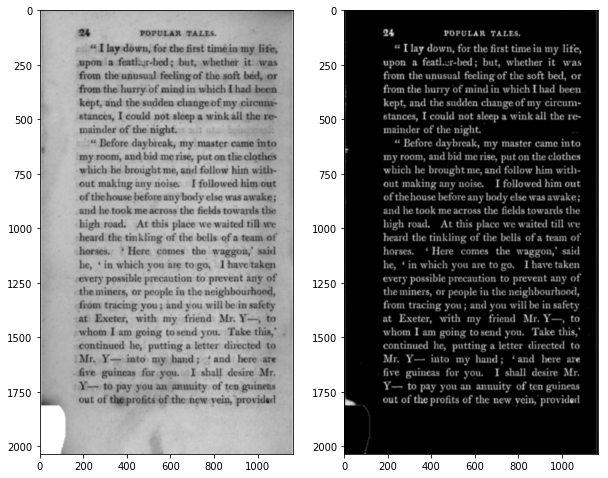

In [6]:
figsize(10, 10)
image = mean(imread("testdata/sample.png")[:, :, :3], 2)
binary = bm.binarize(image)
subplot(121); imshow(image)
subplot(122); imshow(binary)

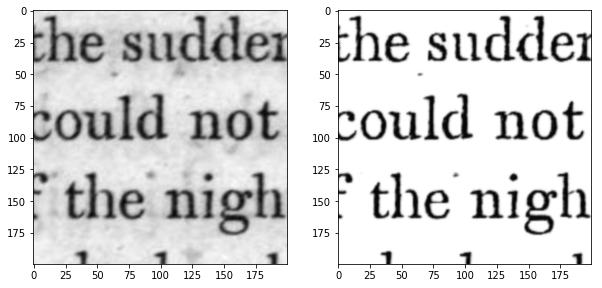

In [7]:
subplot(121); imshow(image[400:600, 400:600])
subplot(122); imshow(1-binary[400:600, 400:600])

# IIR Filters and LSTMs

# IIR Filters

IIR filters:
- filter output depends on previous outputs / internal state
- can retain information over long distances
- are linear filters
- can be approximated by very large convolutions

In [8]:
# simple IIR filter

def iir(signal):
    result = zeros(signal.shape[0])
    y = 0
    for i, x in enumerate(signal):
        y = 0.9 * y + x
        result[i] = y
    return result

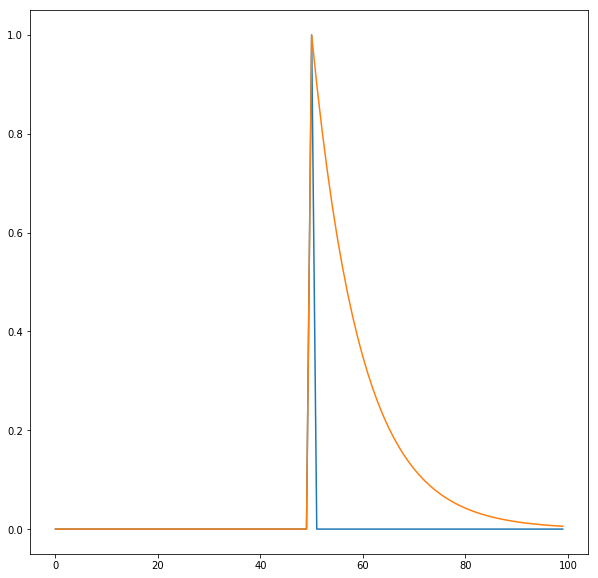

In [9]:
# simple IIR filters

signal = zeros(100); signal[50] = 1.0
plot(signal)
plot(iir(signal))

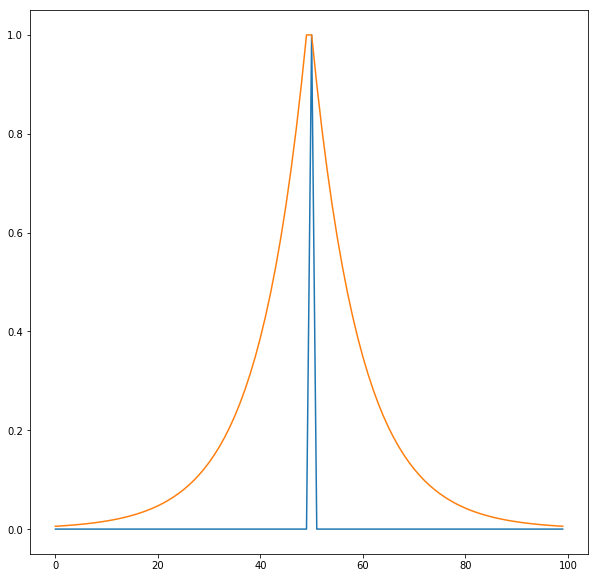

In [10]:
# make IIR filters symmetric / bidirectional by running in each direction and adding
def bidir(signal):
    return iir(signal)+iir(roll(signal,-1)[::-1])[::-1]
plot(signal); plot(bidir(signal))

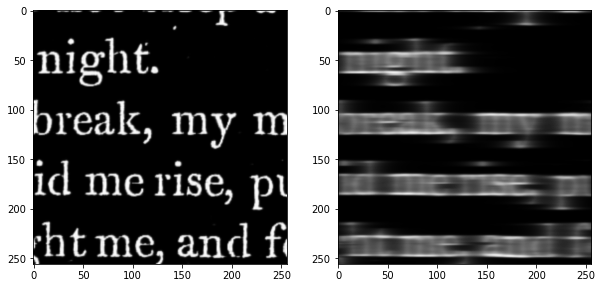

In [11]:
# apply an IIR filter to each row of an image
def rowwise(image):
    result = zeros(image.shape)
    for i in range(len(image)):
        result[i, :] = bidir(image[i, :])
    return result

patch = binary[500:756, 500:756]

subplot(121); imshow(patch); subplot(122); imshow(rowwise(patch))

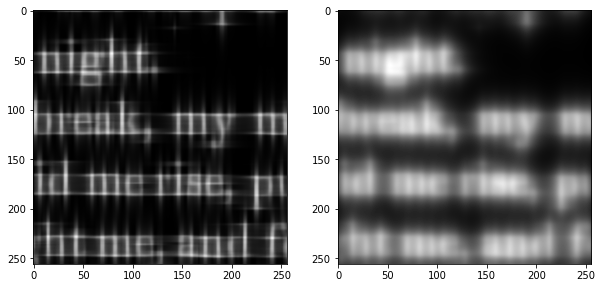

In [12]:
# make it multidimensional by applying it separately to each dimension
subplot(121); imshow(rowwise(patch) + rowwise(patch.T).T)
subplot(122); imshow(rowwise(rowwise(patch).T).T)

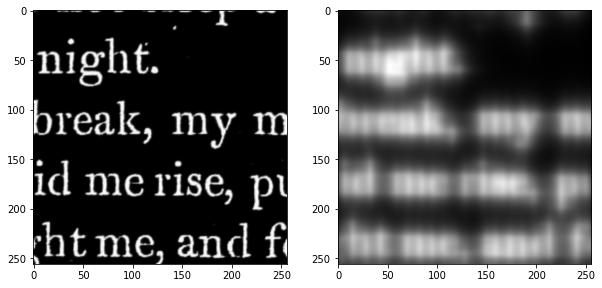

In [13]:
# make it multidimensional by applying it separately to each dimension
subplot(121); imshow(patch)
subplot(122); imshow(rowwise(rowwise(patch).T).T)

# LSTMs and IIRs

- LSTMs are non-linear generalizations of IIR filters
- LSTMs can be applied to images rowwise, then columnwise
- such layers look like convolutional layers, but...
  - can implement very large footprint filters with small layers
  - can propagate information over long distances

In [63]:
# here: 2D LSTM can propagate background/foreground statistics across the entire image
bm.model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): LSTM2(
    (hlstm): RowwiseLSTM(
      (lstm): LSTM(8, 4, bidirectional=1)
    )
    (vlstm): RowwiseLSTM(
      (lstm): LSTM(8, 4, bidirectional=1)
    )
  )
  (4): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
  (5): Sigmoid()
)

# Training

Training data for `ocrobin-train` is stored in tarfiles, with binary images and corresponding grayscale images.

In [64]:
%%bash
tar -ztvf testdata/bindata.tgz | sed 5q

drwxrwxr-x tmb/tmb           0 2018-04-17 10:27 ./
-rw-rw-r-- tmb/tmb      391766 2018-04-10 09:35 ./A001BIN.bin.png
-rw-rw-r-- tmb/tmb     6021129 2018-04-10 09:35 ./A001BIN.gray.png
-rw-rw-r-- tmb/tmb      226629 2018-04-10 09:36 ./A002BIN.bin.png
-rw-rw-r-- tmb/tmb     2685607 2018-04-10 09:36 ./A002BIN.gray.png


tar: write error


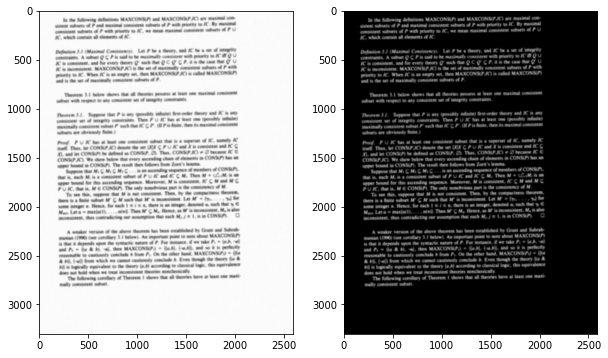

In [71]:
# training data is artificially generated
from dlinputs import tarrecords
data = tarrecords.tariterator(open("testdata/bindata.tgz"))
for i in range(4): sample = data.next()
subplot(121); imshow(sample["gray.png"])
subplot(122); imshow(sample["bin.png"])

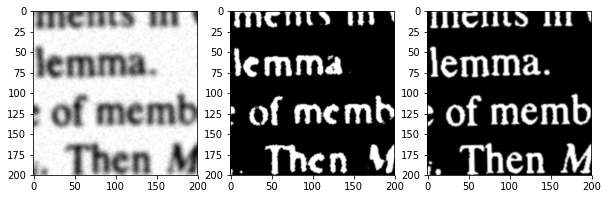

In [74]:
# simple thresholding vs DL binarization
subplot(131); imshow(sample["gray.png"][1500:1700,1500:1700])
subplot(132); imshow(sample["gray.png"][1500:1700,1500:1700] < 0.5)
subplot(133); imshow(sample["bin.png"][1500:1700,1500:1700])

In [73]:
# use the ocrobin-train binary for training on this kind of data
!ocrobin-train --maxtrain 10 -d testdata/bindata.tgz -o temp

__key__ './A001BIN'
__source__ 'testdata/bindata.tgz'
bin.png float32 (3300, 2592)
gray.png float32 (3300, 2592)
__key__ <type 'list'> ['./A002BIN']
__source__ <type 'list'> ['testdata/bindata.tgz']
input float32 (1, 3300, 2592, 1)
output float32 (1, 3300, 2592, 1)
ntrain 0
Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): LSTM2(
    (hlstm): RowwiseLSTM(
      (lstm): LSTM(8, 4, bidirectional=1)
    )
    (vlstm): RowwiseLSTM(
      (lstm): LSTM(8, 4, bidirectional=1)
    )
  )
  (4): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
  (5): Sigmoid()
)
0 0 ['./A001BIN'] 0.20396478 ['./A001BIN'] 0.42967606 0.4580248 lr 0.1
/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
1 1 ['./A004BIN'] 0.19940192 ['./A004BIN'] 0.42361

# Summary

- DL models using 2D LSTMs work well for binarization
- 2D LSTMs are a generalization of separable IIR filters
- Example of models trained completely on synthetic data

# Related Tasks

Tasks related to binarization are:

- resolution enhancement / upscaling
- noise removal

These are important for camera-based capture

# Resolution Enhancement / Noise Removal

- also grayscale-to-binary, like binarization models
- these tasks require encoding shape priors (knowlege of character shapes) in the DL model
- we can accomplish that by U-nets or similar architectures
- doing so makes the method script/content dependent